In [14]:
from sklearn.cluster import KMeans, DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import trustworthiness
from tqdm import tqdm
import umap
import seaborn as sns

## Dimensionality Reduction

In [15]:
df_path = os.path.join('..','..', 'src', 'graph_benchmark', 'user_embeddings.csv')
df = pd.read_csv(df_path)
user_ids = df['user_id']
df = df.drop(columns=['id', 'user_id'])
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,-0.014819,0.318998,-0.232075,-0.615343,-0.632123,-0.183650,-0.352888,0.179700,-0.725622,-0.419344,-0.308318,-0.339443,-0.078309,0.249626,-0.238153,-0.837255,0.219638,-1.231892,-1.025371,0.719451,0.615526,-0.518422,-0.094110,-0.547264,-0.069439,0.195289,-0.016826,-0.088550,-0.390154,0.293075,-0.236445,-0.041593
1,0.480526,-0.478583,-0.251820,-0.590413,-0.980972,-0.160369,-0.210526,-0.210529,-0.432922,-0.585469,0.530155,-0.689058,0.852341,-0.128762,-0.081116,-1.571188,-0.030212,-0.708152,-0.671133,1.225680,-0.284821,-0.478685,-0.823631,0.412273,1.121179,0.914964,0.148406,0.198883,-0.253538,0.603116,-0.868820,-0.715891
2,-0.064912,-3.223288,-7.397039,-0.965528,-7.839769,1.247723,-6.321599,-7.773978,3.188324,-2.255675,5.475267,-7.414062,5.663140,-0.115411,-7.645758,5.513639,-0.505639,-4.811618,3.496511,-3.429957,5.230490,5.036043,7.947283,5.757581,-2.646831,-8.460135,-7.081692,-1.930002,-2.921444,1.235394,-7.006282,7.751076
3,0.462409,1.145017,0.264851,0.693812,0.557005,-0.761985,1.343561,-0.416964,-0.348923,0.105182,1.334126,0.250709,0.608336,-0.462427,0.666211,-0.334300,-0.222794,1.063601,0.259773,-0.689367,-0.530849,0.158106,0.425445,0.183280,1.544957,-0.457620,-1.152213,1.256382,0.732002,-0.148850,0.893864,0.958752
4,-0.262272,-2.171113,-8.050799,-0.177136,-6.777208,1.352292,-6.296734,-7.686207,3.767580,-2.011669,5.828158,-9.208178,4.580647,-0.118799,-6.900783,5.783209,-0.518081,-5.162145,4.530379,-3.872232,4.987920,5.050488,9.208765,7.296651,-3.900183,-9.362906,-8.251870,-2.196878,-2.124597,0.880948,-6.419295,8.537656


In [16]:
scaler = MinMaxScaler()
features_to_scale = list(df.columns)
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,0.907854,0.425072,0.736971,0.876904,0.829482,0.072986,0.800048,0.911009,0.198437,0.220034,0.206673,0.603336,0.170044,0.898324,0.838873,0.111096,0.112249,0.383731,0.346021,0.557959,0.659510,0.048752,0.083826,0.075704,0.812322,0.878105,0.841206,0.239927,0.824614,0.153847,0.584405,0.180478
1,0.960608,0.340953,0.735311,0.879136,0.794646,0.074777,0.816382,0.874737,0.242739,0.206500,0.302839,0.580069,0.274915,0.861557,0.853493,0.037160,0.092868,0.434867,0.382393,0.604708,0.605081,0.054226,0.015692,0.178048,0.950734,0.936933,0.857064,0.261570,0.833775,0.187088,0.538077,0.121991
2,0.902519,0.051472,0.134510,0.845553,0.109742,0.183067,0.115220,0.171720,0.790829,0.070437,0.870007,0.132507,0.817025,0.862854,0.149241,0.750882,0.055989,0.034224,0.810309,0.174773,0.938495,0.813886,0.834861,0.748176,0.512692,0.170589,0.163142,0.101272,0.654863,0.254879,0.088449,0.856397
3,0.958679,0.512192,0.778755,0.994109,0.948225,0.028509,0.994692,0.855549,0.255452,0.262764,0.395049,0.642612,0.247419,0.829135,0.923067,0.161763,0.077930,0.607852,0.477974,0.427859,0.590209,0.141945,0.132351,0.153624,1.000000,0.824734,0.732235,0.341196,0.899867,0.106465,0.667211,0.267246
4,0.881501,0.162443,0.079540,0.916136,0.215847,0.191109,0.118072,0.179878,0.878502,0.090315,0.910481,0.013106,0.695043,0.862525,0.218596,0.778038,0.055024,0.000000,0.916463,0.133930,0.923831,0.815876,0.952679,0.912332,0.366986,0.096794,0.050832,0.081177,0.708301,0.216876,0.131452,0.924623


In [17]:
# Dimensionality reduction using UMAP
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(df)
embedding_scaler = MinMaxScaler()
embedding = embedding_scaler.fit_transform(embedding)
embedding[5:]

/home/acaia/Analysa/Analysa/.analysa/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[0.43570116, 0.7406056 , 0.7474958 ],
       [0.4670952 , 0.7651757 , 0.6548248 ],
       [0.45773008, 0.8035545 , 0.59872514],
       ...,
       [0.3446426 , 0.3080871 , 0.05826604],
       [0.994468  , 0.23018898, 0.9941267 ],
       [0.33746737, 0.31332433, 0.06926665]], dtype=float32)

In [18]:
# Measuring the trustworthiness of the reduction
trustworthiness = trustworthiness(df, embedding, n_neighbors=6)
print(f"Trustworthiness: {trustworthiness}")

Trustworthiness: 0.9857966064860091


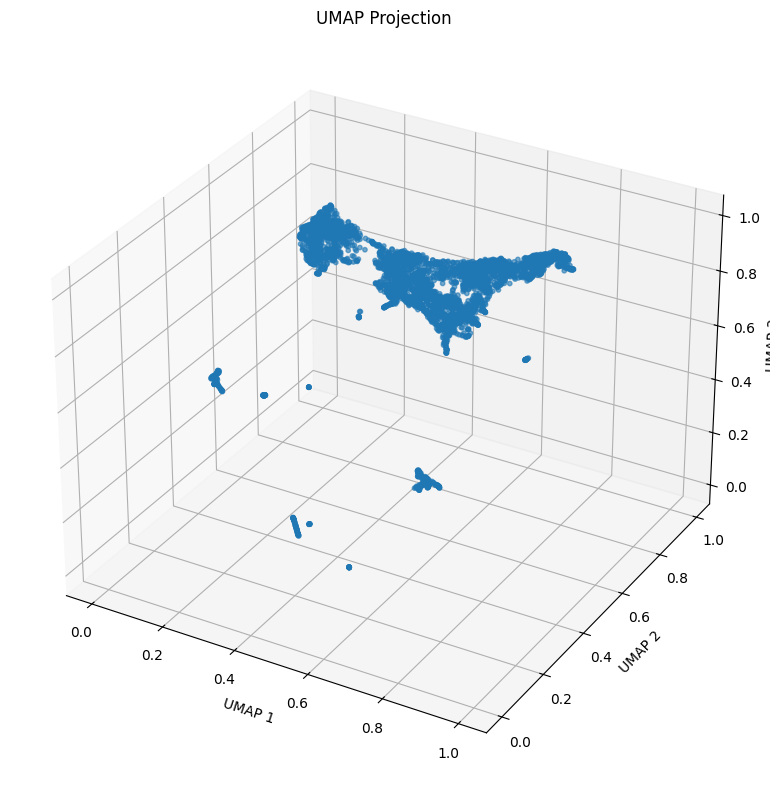

In [19]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embedding[:,0],
    embedding[:,1],
    embedding[:,2],
    alpha=0.6,
    s=10
)

ax.set_title('UMAP Projection')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')

plt.tight_layout()
plt.show()

## Clustering

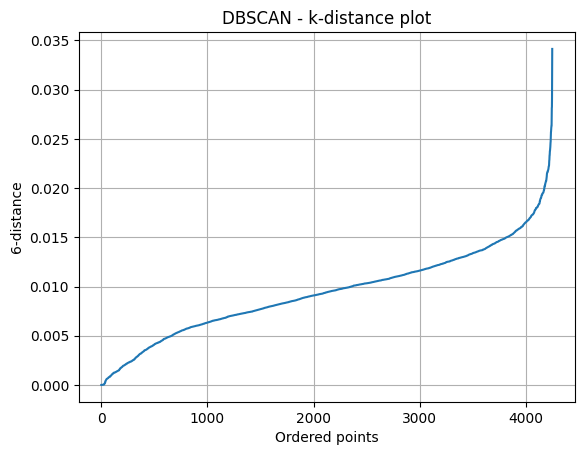

In [20]:
from sklearn.neighbors import NearestNeighbors

min_samples = 6 # Thus 2 * Latent dimension
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(embedding)
distances,_= nbrs.kneighbors(embedding)
k_distances = np.sort(distances[:,min_samples - 1])

plt.plot(k_distances)
plt.xlabel("Ordered points")
plt.ylabel(f"{min_samples}-distance")
plt.title("DBSCAN - k-distance plot")
plt.grid()
plt.show()

In [23]:
dbscan = DBSCAN(eps=0.017,min_samples=6)
cluster_predictions = dbscan.fit_predict(embedding)

n_clusters = len(set(cluster_predictions)) - (1 if -1 in cluster_predictions else 0)
n_noise = list(cluster_predictions).count(-1)

print(f"Numero di cluster trovati: {n_clusters}")
print(f"Punti etichettati come noise: {n_noise} ({n_noise / len(cluster_predictions):.2%})")


Numero di cluster trovati: 16
Punti etichettati come noise: 42 (0.99%)


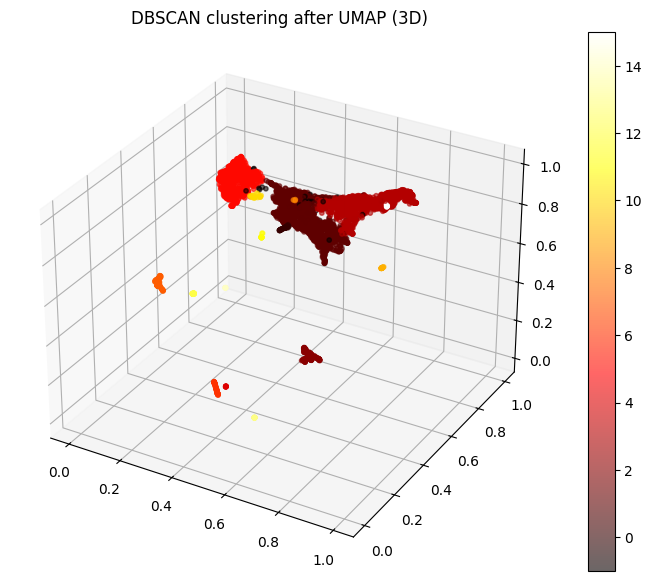

In [24]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embedding[:, 0], embedding[:, 1], embedding[:, 2],
    c=cluster_predictions, cmap='hot', s=10, alpha=0.6
)
ax.set_title("DBSCAN clustering after UMAP (3D)")
plt.colorbar(scatter)
plt.show()